## Introduction 

In [1]:
pip install fast-histogram

Note: you may need to restart the kernel to use updated packages.


In [42]:
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')
import numpy as np
import pandas as pd
import datetime as dt
import pylab
from matplotlib import pyplot as plt
from fast_histogram import histogram1d, histogram2d
%matplotlib inline
import scipy as sc
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import re
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action="ignore")


In [93]:
fifa = pd.read_csv('2019fifadata.csv')
fifa = pd.DataFrame(fifa)
print(fifa.columns)
print(fifa.info())

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

We'll look at how to predict a player's wage using the [FIFA dataset](https://www.kaggle.com/karangadiya/fifa19) . I'll remove columns that don't provide useful information (Unnamed:0, ID, Name, Photo, Flag, Club Logo, and Real Face). As we have 18,207 entries and multiple columns are missing 48 values, my instinct is that these rows are missing information in these columns. As such, I'll remove rows missing information in 48 cells. 

Columns LS through RB are missing values in over two thousand cells and while it's not obvious what each variable represents (there's no information on the Kaggle page and it's not immediately clear on the sofifa.com page), they could contain valuable information. Each value is a string of a number plus another number, so I'm going to strip the addition sign and the second number, and populate these cells with the first number. I will then fill the missing values with the mean.

Joined, Jersey Number, Loaned From, and Release Clause

After these updates, we're still missing values in Club, Contract Valid Until, and Position columns. While I could go through and find the information on each of these, I don't think that would be a great use of time for this project, so I'm going to drop rows for which there aren't values for Club/Contract valid until and hope this takes care of rows lacking a value in Position as well. Finally, Club is a categorical variable with over 650 categories, which will be a pain to create/utilize dummies for, so I will remove this column.

We've managed to clean up our data and keep over 98% of the rows. If we have trouble coming up with a model, we'll look at adding back some columns we've removed.

In [94]:
fifa = fifa.dropna(thresh=48, axis=0)

variables = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']
# fifa[variables].loc[:, variables[0]][0]

# for i, row in fifa.iterrows():
#     for variable in variables:
#         if(pd.isnull(row[variable])):
#             fifa.loc[i, variable] = fifa[variable].astype(float).mean()

# for i, row in fifa.iterrows():
#     for variable in variables:
#         try:
#           fifa.iloc[i, fifa.columns.get_loc(variable)] = fifa.iloc[i, fifa.columns.get_loc(variable)].apply(lambda x: x.split('+')[0])
#         except ValueError: 
#             pass        
#     if(pd.isnull(row[variable])):
#         fifa.loc[i, variable] = fifa[variable].astype(float).mean()

data = fifa[variables]
df = data.astype(str).apply(lambda x: x.str.split('+').str[0])
df = df.astype(float)
df.fillna(df.mean(), inplace=True)
df.head(10)

# pd.options.display.max_columns = None
# fifa.head()
# fifa.LS

LS        ST        RS        LW        LF        CF        RF  \
0  88.00000  88.00000  88.00000  92.00000  93.00000  93.00000  93.00000   
1  91.00000  91.00000  91.00000  89.00000  90.00000  90.00000  90.00000   
2  84.00000  84.00000  84.00000  89.00000  89.00000  89.00000  89.00000   
3  57.81547  57.81547  57.81547  59.03765  58.71939  58.71939  58.71939   
4  82.00000  82.00000  82.00000  87.00000  87.00000  87.00000  87.00000   
5  83.00000  83.00000  83.00000  89.00000  88.00000  88.00000  88.00000   
6  77.00000  77.00000  77.00000  85.00000  84.00000  84.00000  84.00000   
7  87.00000  87.00000  87.00000  86.00000  87.00000  87.00000  87.00000   
8  73.00000  73.00000  73.00000  70.00000  71.00000  71.00000  71.00000   
9  57.81547  57.81547  57.81547  59.03765  58.71939  58.71939  58.71939   

         RW        LAM        CAM        RAM        LM        LCM         CM  \
0  92.00000  93.000000  93.000000  93.000000  91.00000  84.000000  84.000000   
1  89.00000  88.000000  88.000000  88.000000  88.00000  81.000000  81.000000   
2  89.00000  89.000000  89.000000  89.000000  88.00000  81.000000  81.000000   
3  59.03765  58.983129  58.983129  58.983129  59.73471  58.220878  58.220878   
4  87.00000  88.000000  88.000000  88.000000  88.00000  87.000000  87.000000   
5  89.00000  89.000000  89.000000  89.000000  89.00000  82.000000  82.000000   
6  85.00000  87.000000  87.000000  87.000000  86.00000  88.000000  88.000000   
7  86.00000  85.000000  85.000000  85.000000  84.00000  79.000000  79.000000   
8  70.00000  71.000000  71.000000  71.000000  72.00000  75.000000  75.000000   
9  59.03765  58.983129  58.983129  58.983129  59.73471  58.220878  58.220878   

         RCM        RM        LWB        LDM        CDM        RDM        RWB  \
0  84.000000  91.00000  64.000000  61.000000  61.000000  61.000000  64.000000   
1  81.000000  88.00000  65.000000  61.000000  61.000000  61.000000  65.000000   
2  81.000000  88.00000  65.000000  60.000000  60.000000  60.000000  65.000000   
3  58.220878  59.73471  57.513274  56.825146  56.825146  56.825146  57.513274   
4  87.000000  88.00000  77.000000  77.000000  77.000000  77.000000  77.000000   
5  82.000000  89.00000  66.000000  63.000000  63.000000  63.000000  66.000000   
6  88.000000  86.00000  82.000000  81.000000  81.000000  81.000000  82.000000   
7  79.000000  84.00000  69.000000  68.000000  68.000000  68.000000  69.000000   
8  75.000000  72.00000  81.000000  84.000000  84.000000  84.000000  81.000000   
9  58.220878  59.73471  57.513274  56.825146  56.825146  56.825146  57.513274   

          LB        LCB         CB        RCB         RB  
0  59.000000  47.000000  47.000000  47.000000  59.000000  
1  61.000000  53.000000  53.000000  53.000000  61.000000  
2  60.000000  47.000000  47.000000  47.000000  60.000000  
3  56.806786  55.614626  55.614626  55.614626  56.806786  
4  73.000000  66.000000  66.000000  66.000000  73.000000  
5  60.000000  49.000000  49.000000  49.000000  60.000000  
6  79.000000  71.000000  71.000000  71.000000  79.000000  
7  66.000000  63.000000  63.000000  63.000000  66.000000  
8  84.000000  87.000000  87.000000  87.000000  84.000000  
9  56.806786  55.614626  55.614626  55.614626  56.806786

In [95]:
fifa = fifa.drop(columns=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'])

fifa = pd.concat([fifa, df], axis=1)
pd.options.display.max_columns = None
fifa.head()

Unnamed: 0      ID               Name  Age  \
0           0  158023           L. Messi   31   
1           1   20801  Cristiano Ronaldo   33   
2           2  190871          Neymar Jr   26   
3           3  193080             De Gea   27   
4           4  192985       K. De Bruyne   27   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   

                  Club                                     Club Logo    Value  \
0         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png  €110.5M   
1             Juventus   https://cdn.sofifa.org/teams/2/light/45.png     €77M   
2  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png  €118.5M   
3    Manchester United   https://cdn.sofifa.org/teams/2/light/11.png     €72M   
4      Manchester City   https://cdn.sofifa.org/teams/2/light/10.png    €102M   

    Wage  Special Preferred Foot  International Reputation  Weak Foot  \
0  €565K     2202           Left                       5.0        4.0   
1  €405K     2228          Right                       5.0        4.0   
2  €290K     2143          Right                       5.0        5.0   
3  €260K     1471          Right                       4.0        3.0   
4  €355K     2281          Right                       4.0        5.0   

   Skill Moves       Work Rate   Body Type Real Face Position  Jersey Number  \
0          4.0  Medium/ Medium       Messi       Yes       RF           10.0   
1          5.0       High/ Low  C. Ronaldo       Yes       ST            7.0   
2          5.0    High/ Medium      Neymar       Yes       LW           10.0   
3          1.0  Medium/ Medium        Lean       Yes       GK            1.0   
4          4.0      High/ High      Normal       Yes      RCM            7.0   

      Joined Loaned From Contract Valid Until Height  Weight  Crossing  \
0   1-Jul-04         NaN                 2021    5'7  159lbs      84.0   
1  10-Jul-18         NaN                 2022    6'2  183lbs      84.0   
2   3-Aug-17         NaN                 2022    5'9  150lbs      79.0   
3   1-Jul-11         NaN                 2020    6'4  168lbs      17.0   
4  30-Aug-15         NaN                 2023   5'11  154lbs      93.0   

   Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  Curve  \
0       95.0             70.0          90.0     86.0       97.0   93.0   
1       94.0             89.0          81.0     87.0       88.0   81.0   
2       87.0             62.0          84.0     84.0       96.0   88.0   
3       13.0             21.0          50.0     13.0       18.0   21.0   
4       82.0             55.0          92.0     82.0       86.0   85.0   

   FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  Agility  \
0        94.0         87.0         96.0          91.0         86.0     91.0   
1        76.0         77.0         94.0          89.0         91.0     87.0   
2        87.0         78.0         95.0          94.0         90.0     96.0   
3        19.0         51.0         42.0          57.0         58.0     60.0   
4        83.0         91.0         91.0          78.0         76.0     79.0   

   Reactions  Balance  ShotPower  Jumping  Stamina  Strength  LongShots  \
0       95.0     95.0       85.0     68.0     72.0      59.0       94.0   
1       96.0     70.0 

In [96]:
fifa = fifa.drop(['Unnamed: 0', 'ID', 'Name', 'Photo', 'Flag', 'Club Logo', 'Real Face', 'Joined', 'Loaned From'], axis=1)

fifa.columns


Index(['Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Jersey Number',
       'Contract Valid Until', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause', 'LS',
       'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM',
       'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB'],

In [97]:
fifa = fifa[pd.notnull(fifa['Position'])]
fifa = fifa.drop(['Club', 'Contract Valid Until'], axis=1)
fifa.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18147 entries, 0 to 18206
Data columns (total 78 columns):
Age                         18147 non-null int64
Nationality                 18147 non-null object
Overall                     18147 non-null int64
Potential                   18147 non-null int64
Value                       18147 non-null object
Wage                        18147 non-null object
Special                     18147 non-null int64
Preferred Foot              18147 non-null object
International Reputation    18147 non-null float64
Weak Foot                   18147 non-null float64
Skill Moves                 18147 non-null float64
Work Rate                   18147 non-null object
Body Type                   18147 non-null object
Position                    18147 non-null object
Jersey Number               18147 non-null float64
Height                      18147 non-null object
Weight                      18147 non-null object
Crossing                    18147 non-nul

## Transform Variables

There are quite a few columns that are currently being read as objects but should be integers or floats. I'll remove the €, K, and M from the Wage and Value columns and update the values as necessary. I will update the Height column into inches and remove the lbs from the Weight column. I'll perform one hot encoding on the remaining values (Nationality, Preferred Foot Work Rate, Body Type, and Position) to obtain dummies.

In [98]:
fifa.head(5)

Age Nationality  Overall  Potential    Value   Wage  Special  \
0   31   Argentina       94         94  €110.5M  €565K     2202   
1   33    Portugal       94         94     €77M  €405K     2228   
2   26      Brazil       92         93  €118.5M  €290K     2143   
3   27       Spain       91         93     €72M  €260K     1471   
4   27     Belgium       91         92    €102M  €355K     2281   

  Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
0           Left                       5.0        4.0          4.0   
1          Right                       5.0        4.0          5.0   
2          Right                       5.0        5.0          5.0   
3          Right                       4.0        3.0          1.0   
4          Right                       4.0        5.0          4.0   

        Work Rate   Body Type Position  Jersey Number Height  Weight  \
0  Medium/ Medium       Messi       RF           10.0    5'7  159lbs   
1       High/ Low  C. Ronaldo       ST            7.0    6'2  183lbs   
2    High/ Medium      Neymar       LW           10.0    5'9  150lbs   
3  Medium/ Medium        Lean       GK            1.0    6'4  168lbs   
4      High/ High      Normal      RCM            7.0   5'11  154lbs   

   Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  \
0      84.0       95.0             70.0          90.0     86.0       97.0   
1      84.0       94.0             89.0          81.0     87.0       88.0   
2      79.0       87.0             62.0          84.0     84.0       96.0   
3      17.0       13.0             21.0          50.0     13.0       18.0   
4      93.0       82.0             55.0          92.0     82.0       86.0   

   Curve  FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  \
0   93.0        94.0         87.0         96.0          91.0         86.0   
1   81.0        76.0         77.0         94.0          89.0         91.0   
2   88.0        87.0         78.0         95.0          94.0         90.0   
3   21.0        19.0         51.0         42.0          57.0         58.0   
4   85.0        83.0         91.0         91.0          78.0         76.0   

   Agility  Reactions  Balance  ShotPower  Jumping  Stamina  Strength  \
0     91.0       95.0     95.0       85.0     68.0     72.0      59.0   
1     87.0       96.0     70.0       95.0     95.0     88.0      79.0   
2     96.0       94.0     84.0       80.0     61.0     81.0      49.0   
3     60.0       90.0     43.0       31.0     67.0     43.0      64.0   
4     79.0       91.0     77.0       91.0     63.0     90.0      75.0   

   LongShots  Aggression  Interceptions  Positioning  Vision  Penalties  \
0       94.0        48.0           22.0         94.0    94.0       75.0   
1       93.0        63.0           29.0         95.0    82.0       85.0   
2       82.0        56.0           36.0         89.0    87.0       81.0   
3       12.0        38.0           30.0         12.0    68.0       40.0   
4       91.0        76.0           61.0         87.0    94.0       79.0   

   Composure  Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling  \
0       96.0     33.0            28.0           26.0       6.0        11.0   
1       95.0     28.0            31.0           23.0       7.0        11.0   
2       94.0     27.0            24.0           33.0       9.0         9.0   
3       68.0     15.0            21.0           13.0      90.0        85.0   
4       88.0     68.0            58.0           51.0      15.0        13.0   

   GKKicking  GKPositioning  GKReflexes Release Clause        LS        ST  \
0       15.0           14.0         8.0        €226.5M  88.00000  88.00000   
1       15.0           14.0        11.0        €127.1M  91.00000  91.00000   
2       15.0           15.0        11.0        €228.1M  84.00000  84.00000   
3       87.0           88.0        94.0        €138.6M  57.81547  57.81547   
4        5.0           10.0        13.0        €196.4M  82.00000  82.00

In [99]:
fifa['Value'] = fifa['Value'].str.replace('€', '')
fifa['Value'] = fifa['Value'].str.replace('.', '')
fifa['Value'] = fifa['Value'].apply(lambda row: row.replace('K', '000') if 'K' in row else row.replace('M', '000000')).astype(float)

fifa['Wage'] = fifa['Wage'].str.replace('€', '')
fifa['Wage'] = fifa['Wage'].str.replace('.', '')
fifa['Wage'] = fifa['Wage'].apply(lambda row: row.replace('K', '000') if 'K' in row else row.replace('M', '000000')).astype(float)
fifa.head(5)

Age Nationality  Overall  Potential         Value      Wage  Special  \
0   31   Argentina       94         94  1.105000e+09  565000.0     2202   
1   33    Portugal       94         94  7.700000e+07  405000.0     2228   
2   26      Brazil       92         93  1.185000e+09  290000.0     2143   
3   27       Spain       91         93  7.200000e+07  260000.0     1471   
4   27     Belgium       91         92  1.020000e+08  355000.0     2281   

  Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
0           Left                       5.0        4.0          4.0   
1          Right                       5.0        4.0          5.0   
2          Right                       5.0        5.0          5.0   
3          Right                       4.0        3.0          1.0   
4          Right                       4.0        5.0          4.0   

        Work Rate   Body Type Position  Jersey Number Height  Weight  \
0  Medium/ Medium       Messi       RF           10.0    5'7  159lbs   
1       High/ Low  C. Ronaldo       ST            7.0    6'2  183lbs   
2    High/ Medium      Neymar       LW           10.0    5'9  150lbs   
3  Medium/ Medium        Lean       GK            1.0    6'4  168lbs   
4      High/ High      Normal      RCM            7.0   5'11  154lbs   

   Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  \
0      84.0       95.0             70.0          90.0     86.0       97.0   
1      84.0       94.0             89.0          81.0     87.0       88.0   
2      79.0       87.0             62.0          84.0     84.0       96.0   
3      17.0       13.0             21.0          50.0     13.0       18.0   
4      93.0       82.0             55.0          92.0     82.0       86.0   

   Curve  FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  \
0   93.0        94.0         87.0         96.0          91.0         86.0   
1   81.0        76.0         77.0         94.0          89.0         91.0   
2   88.0        87.0         78.0         95.0          94.0         90.0   
3   21.0        19.0         51.0         42.0          57.0         58.0   
4   85.0        83.0         91.0         91.0          78.0         76.0   

   Agility  Reactions  Balance  ShotPower  Jumping  Stamina  Strength  \
0     91.0       95.0     95.0       85.0     68.0     72.0      59.0   
1     87.0       96.0     70.0       95.0     95.0     88.0      79.0   
2     96.0       94.0     84.0       80.0     61.0     81.0      49.0   
3     60.0       90.0     43.0       31.0     67.0     43.0      64.0   
4     79.0       91.0     77.0       91.0     63.0     90.0      75.0   

   LongShots  Aggression  Interceptions  Positioning  Vision  Penalties  \
0       94.0        48.0           22.0         94.0    94.0       75.0   
1       93.0        63.0           29.0         95.0    82.0       85.0   
2       82.0        56.0           36.0         89.0    87.0       81.0   
3       12.0        38.0           30.0         12.0    68.0       40.0   
4       91.0        76.0           61.0         87.0    94.0       79.0   

   Composure  Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling  \
0       96.0     33.0            28.0           26.0       6.0        11.0   
1       95.0     28.0            31.0           23.0       7.0        11.0   
2       94.0     27.0            24.0           33.0       9.0         9.0   
3       68.0     15.0            21.0           13.0      90.0        85.0   
4       88.0     68.0            58.0           51.0      15.0        13.0   

   GKKicking  GKPositioning  GKReflexes Release Clause        LS        ST  \
0       15.0           14.0         8.0        €226.5M  88.00000  88.00000   
1       15.0           14.0        11.0        €127.1M  91.00000  91.00000   
2       15.0           15.0        11.0        €228.1M  84.00000  84.00000   
3       87.0           88.0        94.0        €138.6M  57.81547  57.81547   
4        5.0           

In [101]:
def parse_ht(ht):
    # format: 7' 0.0"
    feet = float(ht[0])
    inches = float(ht[2:])
    return 12*feet + inches


fifa['Height'] = fifa['Height'].apply(lambda x: parse_ht(x))


In [102]:
fifa['Weight'] = fifa['Weight'].apply(lambda x: float(str(x).replace('lbs', '')))

In [103]:
pd.options.display.max_columns = None
fifa.head()

Age Nationality  Overall  Potential         Value      Wage  Special  \
0   31   Argentina       94         94  1.105000e+09  565000.0     2202   
1   33    Portugal       94         94  7.700000e+07  405000.0     2228   
2   26      Brazil       92         93  1.185000e+09  290000.0     2143   
3   27       Spain       91         93  7.200000e+07  260000.0     1471   
4   27     Belgium       91         92  1.020000e+08  355000.0     2281   

  Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
0           Left                       5.0        4.0          4.0   
1          Right                       5.0        4.0          5.0   
2          Right                       5.0        5.0          5.0   
3          Right                       4.0        3.0          1.0   
4          Right                       4.0        5.0          4.0   

        Work Rate   Body Type Position  Jersey Number  Height  Weight  \
0  Medium/ Medium       Messi       RF           10.0    67.0   159.0   
1       High/ Low  C. Ronaldo       ST            7.0    74.0   183.0   
2    High/ Medium      Neymar       LW           10.0    69.0   150.0   
3  Medium/ Medium        Lean       GK            1.0    76.0   168.0   
4      High/ High      Normal      RCM            7.0    71.0   154.0   

   Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  \
0      84.0       95.0             70.0          90.0     86.0       97.0   
1      84.0       94.0             89.0          81.0     87.0       88.0   
2      79.0       87.0             62.0          84.0     84.0       96.0   
3      17.0       13.0             21.0          50.0     13.0       18.0   
4      93.0       82.0             55.0          92.0     82.0       86.0   

   Curve  FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  \
0   93.0        94.0         87.0         96.0          91.0         86.0   
1   81.0        76.0         77.0         94.0          89.0         91.0   
2   88.0        87.0         78.0         95.0          94.0         90.0   
3   21.0        19.0         51.0         42.0          57.0         58.0   
4   85.0        83.0         91.0         91.0          78.0         76.0   

   Agility  Reactions  Balance  ShotPower  Jumping  Stamina  Strength  \
0     91.0       95.0     95.0       85.0     68.0     72.0      59.0   
1     87.0       96.0     70.0       95.0     95.0     88.0      79.0   
2     96.0       94.0     84.0       80.0     61.0     81.0      49.0   
3     60.0       90.0     43.0       31.0     67.0     43.0      64.0   
4     79.0       91.0     77.0       91.0     63.0     90.0      75.0   

   LongShots  Aggression  Interceptions  Positioning  Vision  Penalties  \
0       94.0        48.0           22.0         94.0    94.0       75.0   
1       93.0        63.0           29.0         95.0    82.0       85.0   
2       82.0        56.0           36.0         89.0    87.0       81.0   
3       12.0        38.0           30.0         12.0    68.0       40.0   
4       91.0        76.0           61.0         87.0    94.0       79.0   

   Composure  Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling  \
0       96.0     33.0            28.0           26.0       6.0        11.0   
1       95.0     28.0            31.0           23.0       7.0        11.0   
2       94.0     27.0            24.0           33.0       9.0         9.0   
3       68.0     15.0            21.0           13.0      90.0        85.0   
4       88.0     68.0            58.0           51.0      15.0        13.0   

   GKKicking  GKPositioning  GKReflexes Release Clause        LS        ST  \
0       15.0           14.0         8.0        €226.5M  88.00000  88.00000   
1       15.0           14.0        11.0        €127.1M  91.00000  91.00000   
2       15.0           15.0        11.0        €228.1M  84.00000  84.00000   
3       87.0           88.0        94.0        €138.6M  57.81547  57.81547   
4        5.0     

In [110]:
fifa.describe()

Age       Overall     Potential         Value           Wage  \
count  18147.000000  18147.000000  18147.000000  1.814700e+04   18147.000000   
mean      25.121122     66.253926     71.324076  1.367395e+07    9759.023530   
std        4.669796      6.913320      6.132286  3.993434e+07   22030.250349   
min       16.000000     46.000000     48.000000  0.000000e+00       0.000000   
25%       21.000000     62.000000     67.000000  3.000000e+05    1000.000000   
50%       25.000000     66.000000     71.000000  6.750000e+05    3000.000000   
75%       28.000000     71.000000     75.000000  1.300000e+07    9000.000000   
max       45.000000     94.000000     95.000000  1.185000e+09  565000.000000   

            Special  International Reputation     Weak Foot   Skill Moves  \
count  18147.000000              18147.000000  18147.000000  18147.000000   
mean    1598.002645                  1.113297      2.947154      2.361492   
std      272.882706                  0.394150      0.660498      0.756274   
min      731.000000                  1.000000      1.000000      1.000000   
25%     1457.000000                  1.000000      3.000000      2.000000   
50%     1635.000000                  1.000000      3.000000      2.000000   
75%     1787.000000                  1.000000      3.000000      3.000000   
max     2346.000000                  5.000000      5.000000      5.000000   

       Jersey Number        Height        Weight      Crossing     Finishing  \
count   18147.000000  18147.000000  18147.000000  18147.000000  18147.000000   
mean       19.546096     71.361988    165.982972     49.738414     45.550229   
std        15.947765      2.649738     15.593388     18.364255     19.527445   
min         1.000000     61.000000    110.000000      5.000000      2.000000   
25%         8.000000     69.000000    154.000000     38.000000     30.000000   
50%        17.000000     71.000000    165.000000     54.000000     49.000000   
75%        26.000000     73.000000    176.000000     64.000000     62.000000   
max        99.000000     81.000000    243.000000     93.000000     95.000000   

       HeadingAccuracy  ShortPassing       Volleys     Dribbling  \
count     18147.000000  18147.000000  18147.000000  18147.000000   
mean         52.300766     58.695432     42.912217     55.375158   
std          17.381753     14.696075     17.695900     18.912224   
min           4.000000      7.000000      4.000000      4.000000   
25%          44.000000     54.000000     30.000000     49.000000   
50%          56.000000     62.000000     44.000000     61.000000   
75%          64.000000     68.000000     57.000000     68.000000   
max          94.000000     93.000000     90.000000     97.000000   

              Curve    FKAccuracy   LongPassing   BallControl  Acceleration  \
count  18147.000000  18147.000000  18147.000000  18147.000000  18147.000000   
mean      47.176283     42.866038     52.721386     58.374828     64.612829   
std       18.396009     17.480034     15.325211     16.685643     14.930320   
min        6.000000      3.000000      9.000000      5.000000     12.000000   
25%       34.000000     31.000000     43.000000     54.000000     57.000000   
50%       48.000000     41.000000     56.000000     63.000000     67.000000   
75%       62.000000     57.000000     64.000000     69.000000     75.000000   
max       94.000000     94.000000     93.000000     96.000000     97.000000   

        SprintSpeed       Agility     Reactions       Balance     ShotPower  \
count  18147.000000  18147.000000  18147.000000  18147.000000  18147.000000   
mean      64.726236     63.501295     61.839147     63.964292     55.465201   
std       14.651776     14.768956      9.011056     14.136073     17.235534   
min       12.000000     14.000000     21.000000     16.000000      2.000000   
25%       57.000000     55.000000     56.000000     56.000000     45.000000   
50%       67.000000     66.000000     62.000000     66.000000     59.000000   
75

In [105]:
fifa = pd.concat([fifa, pd.get_dummies(fifa['Nationality'])], axis=1)
fifa = pd.concat([fifa, pd.get_dummies(fifa["Preferred Foot"])], axis=1)
fifa = pd.concat([fifa, pd.get_dummies(fifa["Work Rate"])], axis=1)
fifa = pd.concat([fifa, pd.get_dummies(fifa["Body Type"])], axis=1)
fifa = pd.concat([fifa, pd.get_dummies(fifa["Position"])], axis=1)

# fifa.head()

In [106]:
corr_mat = np.abs((fifa.corr().loc[:, ['Wage']])).sort_values(by='Wage', ascending=False)
corr_mat[:50]

Wage
Wage                      1.000000
International Reputation  0.668612
Value                     0.623457
Overall                   0.571795
Reactions                 0.495598
Potential                 0.486608
RCM                       0.430297
CM                        0.430297
LCM                       0.430297
Composure                 0.419615
ST                        0.388833
LS                        0.388833
RS                        0.388833
CAM                       0.387738
RAM                       0.387738
LAM                       0.387738
LM                        0.385540
RM                        0.385540
CF                        0.381415
RF                        0.381415
LF                        0.381415
RW                        0.365175
LW                        0.365175
Special                   0.347830
RWB                       0.329620
LWB                       0.329620
Vision                    0.315311
RDM                       0.312327
LDM                       0.312327
CDM                       0.312327
ShortPassing              0.296615
LB                        0.289612
RB                        0.289612
BallControl               0.277598
LongPassing               0.276646
Skill Moves               0.263163
Curve                     0.259511
ShotPower                 0.258357
Volleys                   0.257357
LongShots                 0.249074
Dribbling                 0.237123
FKAccuracy                0.236388
Crossing                  0.232828
Positioning               0.226763
Penalties                 0.222604
RCB                       0.219732
CB                        0.219732
LCB                       0.219732
Finishing                 0.217522
Aggression                0.194494

In [111]:
# fifa = pd.get_dummies(fifa)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
fifa.corr()

Age   Overall  Potential     Value      Wage  \
Age                       1.000000  0.453354  -0.252259  0.059044  0.141519   
Overall                   0.453354  1.000000   0.660947  0.499650  0.571795   
Potential                -0.252259  0.660947   1.000000  0.458136  0.486608   
Value                     0.059044  0.499650   0.458136  1.000000  0.623457   
Wage                      0.141519  0.571795   0.486608  0.623457  1.000000   
Special                   0.237009  0.607108   0.384359  0.310185  0.347830   
International Reputation  0.253985  0.499596   0.373024  0.454614  0.668612   
Weak Foot                 0.059964  0.212464   0.162818  0.134889  0.140993   
Skill Moves               0.027814  0.414363   0.354107  0.263998  0.263163   
Jersey Number            -0.241156 -0.218931  -0.010474 -0.075694 -0.086561   
Height                    0.082844  0.038480  -0.010120 -0.005229  0.019526   
Weight                    0.230256  0.154463  -0.007297  0.033016  0.064692   
Crossing                  0.130663  0.394849   0.246188  0.211865  0.232828   
Finishing                 0.068789  0.332674   0.243436  0.209722  0.217522   
HeadingAccuracy           0.147204  0.340602   0.200665  0.152517  0.187954   
ShortPassing              0.133117  0.502275   0.368765  0.271036  0.296615   
Volleys                   0.142766  0.391445   0.254879  0.235260  0.257357   
Dribbling                 0.010373  0.372358   0.314867  0.228047  0.237123   
Curve                     0.143432  0.419501   0.279886  0.241323  0.259511   
FKAccuracy                0.193495  0.397004   0.230620  0.221573  0.236388   
LongPassing               0.181710  0.483639   0.320960  0.252210  0.276646   
BallControl               0.085090  0.460034   0.354149  0.257700  0.277598   
Acceleration             -0.158621  0.197178   0.235020  0.142835  0.125050   
SprintSpeed              -0.151523  0.210971   0.237097  0.143879  0.130373   
Agility                  -0.019542  0.265253   0.222774  0.161986  0.156387   
Reactions                 0.453174  0.850071   0.513415  0.431433  0.495598   
Balance                  -0.089991  0.103245   0.138334  0.095665  0.088981   
ShotPower                 0.156965  0.441080   0.288124  0.234292  0.258357   
Jumping                   0.177371  0.264409   0.108986  0.083681  0.129657   
Stamina                   0.097859  0.365652   0.202497  0.175269  0.177569   
Strength                  0.333331  0.349318   0.075144  0.098315  0.139231   
LongShots                 0.155191  0.420791   0.266617  0.235307  0.249074   
Aggression                0.265250  0.395142   0.170622  0.149050  0.194494   
Interceptions             0.197841  0.321174   0.154665  0.118850  0.157377   
Positioning               0.082742  0.356497   0.245445  0.214562  0.226763   
Vision                    0.187610  0.498683   0.347761  0.291429  0.315311   
Penalties                 0.139435  0.341639   0.224465  0.194923  0.222604   
Composure                 0.391083  0.727646   0.439959  0.366389  0.419615   
Marking                   0.142822  0.286364   0.162564  0.113876  0.145582   
StandingTackle            0.119645  0.252395   0.143325  0.094817  0.126260   
SlidingTackle             0.103036  0.222496   0.128621  0.077303  0.110973   
GKDiving                  0.101212 -0.025988  -0.053422 -0.033074 -0.025617   
GKHandling                0.106456 -0.025150  -0.054736 -0.031622 -0.025241   
GKKicking                 0.104920 -0.029394  -0.059027 -0.031994 -0.028361   
GKPositioning             0.116324 -0.017677  -0.052518 -0.031829 -0.025515   
GKReflexes                0.103279 -0.023280  -0.053290 -0.033436 -0.026026   
LS                        0.263164  0.620366   0.403931  0.353875  0.388833   
ST                        0.263164  0.620366   0.403931  0.353875  0.388833   
RS                        0.263164  0.620366   0.403931  0.353875  0.388833   
LW                        0.183155  0.570285   0.407976  0.341783  0.365175   
LF

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for International Reputation feature. 







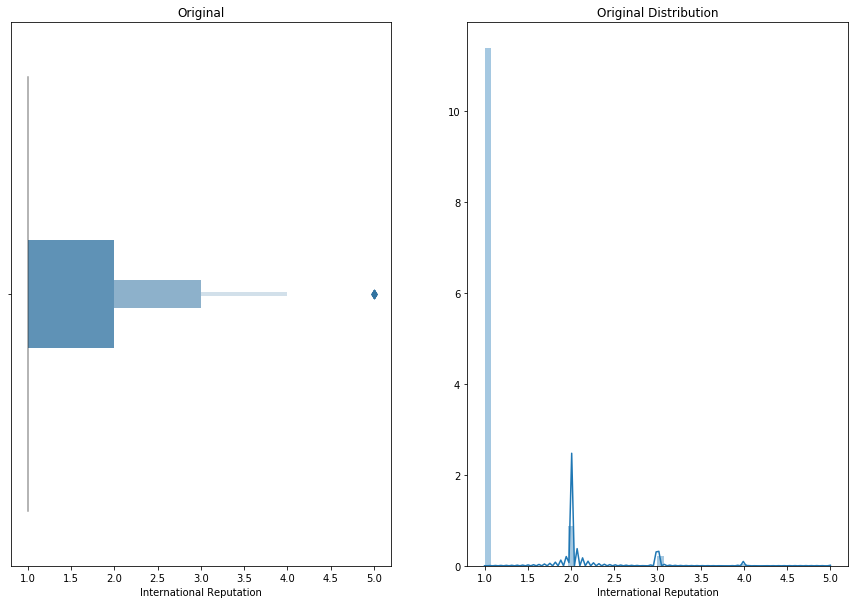

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for Value feature. 







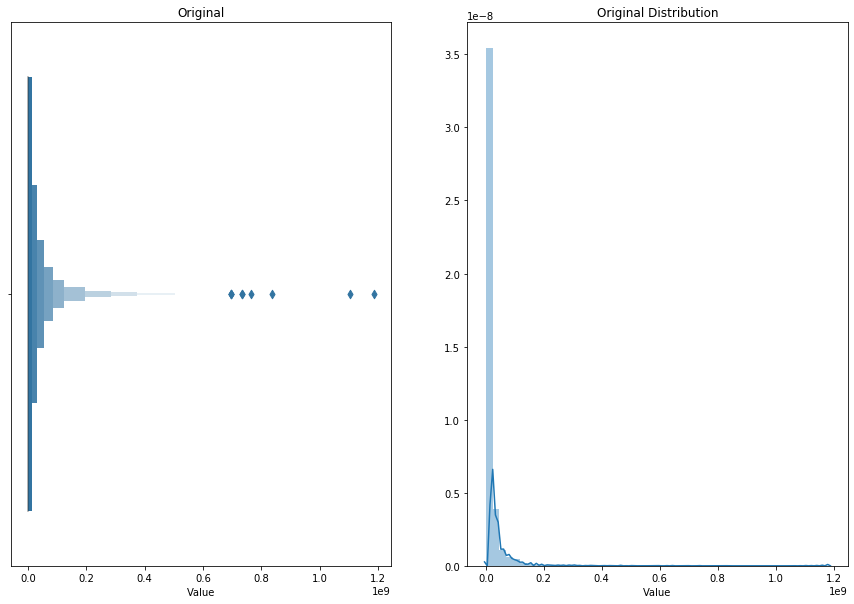

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for Overall feature. 







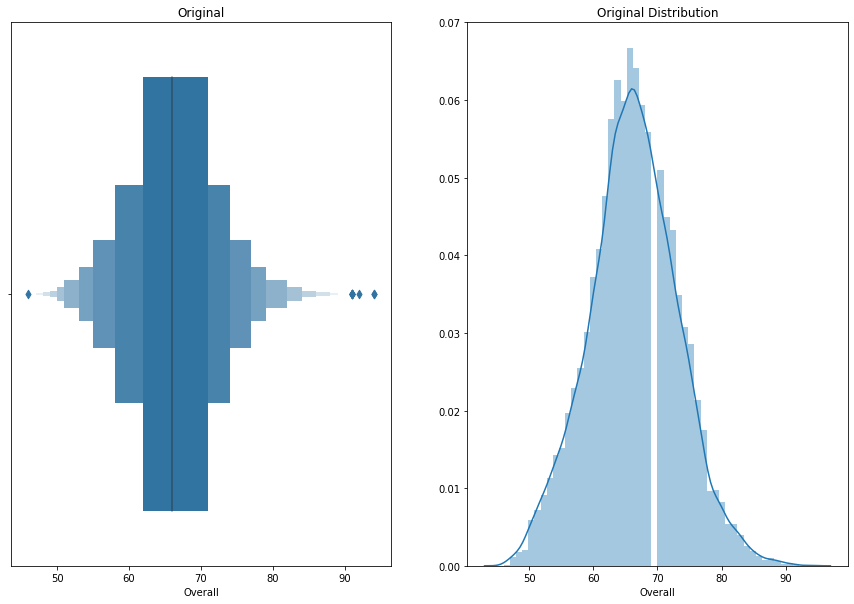

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for Reactions feature. 







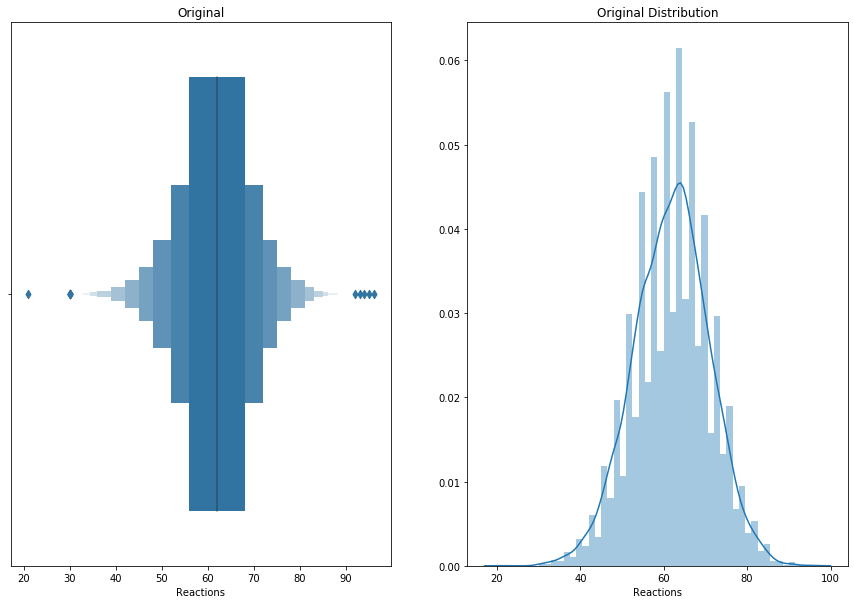

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for Potential feature. 







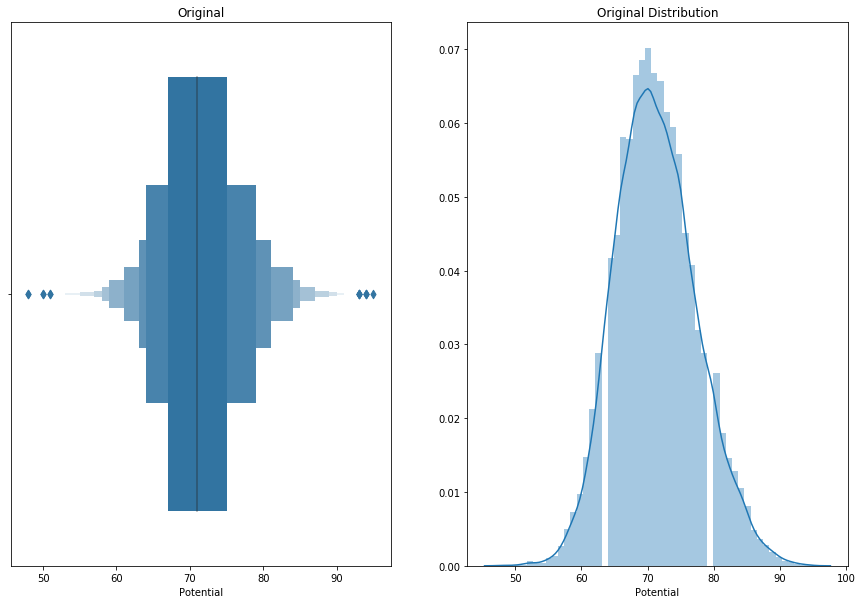

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for RCM feature. 





ValueError: color kwarg must have one color per data set. 2 data sets and 1 colors were provided

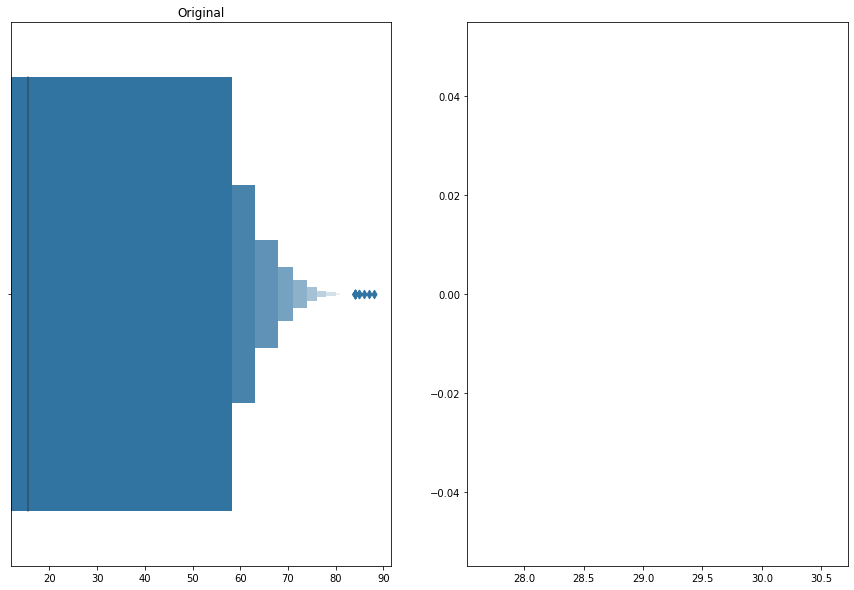

In [108]:
# Specify a list with features I want to test for normality. 
# Visuals for outliers and normality
features_to_test = fifa[['International Reputation', 'Value', 'Overall', 'Reactions', 'Potential', 'RCM', 'CM', 'LCM', 'Composure']]
for feat in features_to_test:
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (15,10))
    plt.subplot(1,2,1)
    sns.boxenplot(fifa[feat])
    plt.title('Original')
    print('\n')
    plt.subplot(1, 2, 2)
    sns.distplot(fifa[feat])
    plt.title('Original Distribution')
    print('\n')
    plt.show()

## First Model

This model was run using features with absolute values of the correlation with the target greater that 0.4. I will first run it with cross validation and then with training and testing sets.

The cross validation is clearly terrible. However, the model with testing and training sets has a very high R-squared and a lower MSE than the model with cross validation. I'm concerned because these variables were highly correlated with the feature. Perhaps I didn't use enough variables, so I'll add some new variables to see if we can make it any better.

In [16]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = fifa['Wage']
X = fifa[['International Reputation', 'Value', 'Overall', 'Reactions', 'Potential', 'RCM', 'CM', 'LCM', 'Composure']]

rfr.fit(X, Y)
cross_val_scores =  cross_val_score(rfr, X, Y, cv=10)
nmse_cross_val_score = cross_val_score(rfr, X, Y, cv=10, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)
print('\n')
print('Feature Importances: ', rfr.feature_importances_)

Mean R-Squared:  -0.06698319454133578
Cross Validation Scores:  [-0.1076981   0.00637153 -0.06841943  0.01989613 -0.05419416  0.00873567
  0.00492057 -0.04457633 -0.08868355 -0.34618428]


Mean Negative MSE:  -323173484.36494756
Cross Validation MSE Scores:  [-2.95799599e+09 -1.54782695e+08 -6.46050979e+07 -2.83146573e+07
 -1.27162918e+07 -6.54932266e+06 -2.86026901e+06 -2.12908281e+06
 -1.12564617e+06 -6.55791345e+05]


Feature Importances:  [0.01384297 0.05031427 0.77363465 0.03487631 0.02394683 0.0167893
 0.00132467 0.01735189 0.00363767 0.01726114 0.00166724 0.04535306]


In [24]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
rfr.fit(X, Y)

Y = fifa['Wage']
X = fifa[['International Reputation', 'Value', 'Overall', 'Reactions', 'Potential', 'RCM', 'CM', 'LCM', 'Composure']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 465)

Y_preds_train = rfr.predict(X_train)
Y_preds_test = rfr.predict(X_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.9669867999835087
-----Test set statistics-----
R-squared of the model on the test set is: 0.9679355920397104
Mean absolute error of the prediction is: 1776.5061852289125
Mean squared error of the prediction is: 15085707.217215799
Root mean squared error of the prediction is: 3884.0323398776945
Mean absolute percentage error of the prediction is: inf


## Second Model

This model uses the fifty features most correlated with the target. The performance of the cross validation model has improved slightly - the R-squared is a touch higher and the MSE a bit smaller. The evaluation metrics for the training and test sets are essentially the same.

In [14]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = fifa['Wage']
X = fifa[['International Reputation', 'Value' , 'Overall', 'Reactions', 'Potential' , 'RCM' ,
          'CM', 'LCM', 'Composure', 'ST', 'LS', 'RS', 'CAM', 'RAM', 'LAM', 'LM','RM', 'CF', 
          'RF', 'LF', 'RW', 'LW', 'Special', 'RWB', 'LWB', 'Vision', 'RDM', 'LDM', 'CDM', 'ShortPassing',
          'LB', 'RB', 'BallControl', 'LongPassing', 'Skill Moves', 'Curve', 'ShotPower', 'Volleys',
          'LongShots', 'Dribbling', 'FKAccuracy', 'Crossing', 'Positioning', 'Penalties', 'RCB', 'CB', 
          'LCB', 'Finishing', 'Aggression']]

rfr.fit(X, Y)
cross_val_scores =  cross_val_score(rfr, X, Y, cv=10)
nmse_cross_val_score = cross_val_score(rfr, X, Y, cv=10, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)
print('\n')
print('Feature Importances: ', rfr.feature_importances_)

Mean R-Squared:  -0.029474554946110045
Cross Validation Scores:  [ 0.00965037  0.05454049  0.02190973  0.04131572 -0.00578386  0.03394867
 -0.0186799  -0.00565061 -0.0090238  -0.41697236]


Mean Negative MSE:  -295735641.4908054
Cross Validation MSE Scores:  [-2.69871314e+09 -1.46451374e+08 -5.88485930e+07 -2.80860673e+07
 -1.22289144e+07 -6.32592625e+06 -2.95224052e+06 -2.04451902e+06
 -1.04503932e+06 -6.60599779e+05]


Feature Importances:  [6.28350876e-03 1.53333315e-02 7.57596588e-01 8.72924360e-03
 8.30817961e-03 1.92299822e-03 2.02005728e-04 2.00371224e-03
 1.24079379e-03 2.32492051e-03 2.99649326e-04 9.48357549e-03
 1.77483700e-03 4.29030622e-04 1.72748177e-03 1.04871087e-04
 2.52496081e-03 1.81478211e-04 1.55143238e-03 7.05385235e-04
 1.46727400e-03 9.53393358e-06 1.57357796e-03 7.67375059e-06
 1.25411452e-03 4.05027598e-04 1.30276564e-03 5.85598397e-04
 9.91437692e-04 6.48427288e-05 1.08896940e-03 1.00103070e-04
 1.30905757e-03 1.57843773e-04 1.63647651e-03 3.68413497e-03
 1.4

In [36]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
rfr.fit(X, Y)

Y = fifa['Wage']
X = fifa[['International Reputation', 'Value' , 'Overall', 'Reactions', 'Potential' , 'RCM' ,
          'CM', 'LCM', 'Composure', 'ST', 'LS', 'RS', 'CAM', 'RAM', 'LAM', 'LM','RM', 'CF', 
          'RF', 'LF', 'RW', 'LW', 'Special', 'RWB', 'LWB', 'Vision', 'RDM', 'LDM', 'CDM', 'ShortPassing',
          'LB', 'RB', 'BallControl', 'LongPassing', 'Skill Moves', 'Curve', 'ShotPower', 'Volleys',
          'LongShots', 'Dribbling', 'FKAccuracy', 'Crossing', 'Positioning', 'Penalties', 'RCB', 'CB', 
          'LCB', 'Finishing', 'Aggression']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 465)

Y_preds_train = rfr.predict(X_train)
Y_preds_test = rfr.predict(X_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.969686006028723
-----Test set statistics-----
R-squared of the model on the test set is: 0.9688804346173671
Mean absolute error of the prediction is: 1720.046831955923
Mean squared error of the prediction is: 14641176.368227731
Root mean squared error of the prediction is: 3826.3790152346032
Mean absolute percentage error of the prediction is: inf


In [19]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = fifa['Wage']
X = fifa[['Overall',  'Value', 'RB', 'Aggression']]

rfr.fit(X, Y)
cross_val_scores =  cross_val_score(rfr, X, Y, cv=10)
nmse_cross_val_score = cross_val_score(rfr, X, Y, cv=10, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)
print('\n')
print('Feature Importances: ', rfr.feature_importances_)

Mean R-Squared:  -0.14441211214357885
Cross Validation Scores:  [-0.20037308 -0.10283524 -0.07018437 -0.03110311 -0.12504249 -0.06125926
 -0.16190481 -0.0814471  -0.17256626 -0.43740538]


Mean Negative MSE:  -353994021.4642366
Cross Validation MSE Scores:  [-3.24458433e+09 -1.73148389e+08 -6.37888347e+07 -3.01816623e+07
 -1.36915684e+07 -7.00837981e+06 -3.35524382e+06 -2.23099052e+06
 -1.23566240e+06 -7.15156203e+05]


Feature Importances:  [0.78320252 0.07603846 0.05896211 0.00345684 0.07834007]


In [21]:
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 90, 100],
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 500, 1000]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

rf_gsc.fit(X, Y)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 66.7min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 89.2min finished


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=12, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)


In [29]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, cri               min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=12, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)terion='mse',
                      max_depth=90, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
       
Y = fifa['Wage']
X = fifa[['Overall',  'Value', 'RB', 'Aggression']]

rfr.fit(X, Y)
cross_val_scores =  cross_val_score(rfr, X, Y, cv=5)
nmse_cross_val_score = cross_val_score(rfr, X, Y, cv=5, scoring='neg_mean_squared_error')

print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)
print('\n')
print('Feature Importances: ', rfr.feature_importances_)

Mean R-Squared:  -0.1489874716193049
Cross Validation Scores:  [-0.23317024  0.07737661  0.00283636 -0.06657898 -0.5254011 ]


Mean Negative MSE:  -416485118.33801675
Cross Validation MSE Scores:  [-2.02457538e+09 -4.43591068e+07 -9.56392295e+06 -2.58997989e+06
 -1.33719955e+06]


Feature Importances:  [0.68077996 0.21734242 0.06478607 0.00110891 0.03598264]


In [31]:
Y = fifa['Wage']
X = fifa[['Overall',  'Value', 'RB', 'Aggression']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 465)

Y_preds_train = rfr.predict(X_train)
Y_preds_test = rfr.predict(X_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.8572251956321619
-----Test set statistics-----
R-squared of the model on the test set is: 0.8687265652147163
Mean absolute error of the prediction is: 3581.7652426382037
Mean squared error of the prediction is: 61761708.02909097
Root mean squared error of the prediction is: 7858.861751493722
Mean absolute percentage error of the prediction is: inf


## Transforming to a Classification Problem

Because these models are performing so poorly under cross validation, I'm going to transform this problem from regression to classification. I will create a new target variable called 'Income Level' that will be determined by the wage - each additional €100K will earn an additional point - €0-€99,999 will have a score of 0, €100,000-199,999 will have a score of 1, etc. Hopefully this will increase the performance of the models.

In [113]:
fifa['Income Level'] = fifa['Wage'].apply(lambda x: 0 if 0 <= x <100000 else 1 if 100000 <= x <200000 
                                          else 2 if 200000 <= x <300000 else 3 if 3000000 <= x <400000
                                          else 4 if 4000000 <= x <500000 else 5)

fifa.head(5)

Age Nationality  Overall  Potential         Value      Wage  Special  \
0   31   Argentina       94         94  1.105000e+09  565000.0     2202   
1   33    Portugal       94         94  7.700000e+07  405000.0     2228   
2   26      Brazil       92         93  1.185000e+09  290000.0     2143   
3   27       Spain       91         93  7.200000e+07  260000.0     1471   
4   27     Belgium       91         92  1.020000e+08  355000.0     2281   

  Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
0           Left                       5.0        4.0          4.0   
1          Right                       5.0        4.0          5.0   
2          Right                       5.0        5.0          5.0   
3          Right                       4.0        3.0          1.0   
4          Right                       4.0        5.0          4.0   

        Work Rate   Body Type Position  Jersey Number  Height  Weight  \
0  Medium/ Medium       Messi       RF           10.0    67.0   159.0   
1       High/ Low  C. Ronaldo       ST            7.0    74.0   183.0   
2    High/ Medium      Neymar       LW           10.0    69.0   150.0   
3  Medium/ Medium        Lean       GK            1.0    76.0   168.0   
4      High/ High      Normal      RCM            7.0    71.0   154.0   

   Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  \
0      84.0       95.0             70.0          90.0     86.0       97.0   
1      84.0       94.0             89.0          81.0     87.0       88.0   
2      79.0       87.0             62.0          84.0     84.0       96.0   
3      17.0       13.0             21.0          50.0     13.0       18.0   
4      93.0       82.0             55.0          92.0     82.0       86.0   

   Curve  FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  \
0   93.0        94.0         87.0         96.0          91.0         86.0   
1   81.0        76.0         77.0         94.0          89.0         91.0   
2   88.0        87.0         78.0         95.0          94.0         90.0   
3   21.0        19.0         51.0         42.0          57.0         58.0   
4   85.0        83.0         91.0         91.0          78.0         76.0   

   Agility  Reactions  Balance  ShotPower  Jumping  Stamina  Strength  \
0     91.0       95.0     95.0       85.0     68.0     72.0      59.0   
1     87.0       96.0     70.0       95.0     95.0     88.0      79.0   
2     96.0       94.0     84.0       80.0     61.0     81.0      49.0   
3     60.0       90.0     43.0       31.0     67.0     43.0      64.0   
4     79.0       91.0     77.0       91.0     63.0     90.0      75.0   

   LongShots  Aggression  Interceptions  Positioning  Vision  Penalties  \
0       94.0        48.0           22.0         94.0    94.0       75.0   
1       93.0        63.0           29.0         95.0    82.0       85.0   
2       82.0        56.0           36.0         89.0    87.0       81.0   
3       12.0        38.0           30.0         12.0    68.0       40.0   
4       91.0        76.0           61.0         87.0    94.0       79.0   

   Composure  Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling  \
0       96.0     33.0            28.0           26.0       6.0        11.0   
1       95.0     28.0            31.0           23.0       7.0        11.0   
2       94.0     27.0            24.0           33.0       9.0         9.0   
3       68.0     15.0            21.0           13.0      90.0        85.0   
4       88.0     68.0            58.0           51.0      15.0        13.0   

   GKKicking  GKPositioning  GKReflexes Release Clause        LS        ST  \
0       15.0           14.0         8.0        €226.5M  88.00000  88.00000   
1       15.0           14.0        11.0        €127.1M  91.00000  91.00000   
2       15.0           15.0        11.0        €228.1M  84.00000  84.00000   
3       87.0           88.0        94.0        €138.6M  57.81547  57.81547   
4        5.0     

In [ ]:
# Finding the best parameters for the classifier.

Y = fifa['Wage']
X = fifa[['Overall',  'Value', 'RB', 'Aggression']]

rfc_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 90, 100],
            'max_features': [2, 3, 4],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 500, 1000]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

rfc_gsc.fit(X, Y)
best_params = rfc_gsc.best_params_
# svr_gsc.best_estimator_
bestc_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rfc)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 49.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 81.6min


In [ ]:
rfc = ensemble.RandomForestClassifier(n_estimators=200)
Y = fifa['Wage']
X = fifa[['International Reputation', 'Value', 'Overall', 'Reactions', 'Potential', 'RCM', 'CM', 'LCM', 'Composure']]

rfr.fit(X, Y)
cross_val_scores =  cross_val_score(rfr, X, Y, cv=10)
nmse_cross_val_score = cross_val_score(rfr, X, Y, cv=10, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)
print('\n')
print('Feature Importances: ', rfr.feature_importances_)